### Анализ СМС трафика телеком оператора

У нас имеются данные о количестве отправленных SMS за январь 2023 года с шагом в 15 минут. В ходе анализа мы будем исследовать особенности поведения трафика, выявлять закономерности и аномалии, а также строить прогнозы различными методами — от простых средних значений до более продвинутых моделей.

In [2]:
import pandas as pd
import seaborn as sns
import warnings 
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

In [3]:
# загрузка данных
data = pd.read_csv('data/telecom_sms_data.csv', parse_dates=['Event time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Event time  2976 non-null   datetime64[ns]
 1   label       2976 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 46.6 KB


In [4]:
# отсортируем по дате (чтобы данные были упорядочены по времени)
data = data.sort_values(by='Event time', ascending=True)
data

,Event time,label
0,2023-01-01 00:00:00,704
1,2023-01-01 00:15:00,213
2,2023-01-01 00:30:00,126
3,2023-01-01 00:45:00,167
4,2023-01-01 01:00:00,210
...,...,...
2971,2023-01-31 22:45:00,287
2972,2023-01-31 23:00:00,295
2973,2023-01-31 23:15:00,225
2974,2023-01-31 23:30:00,253


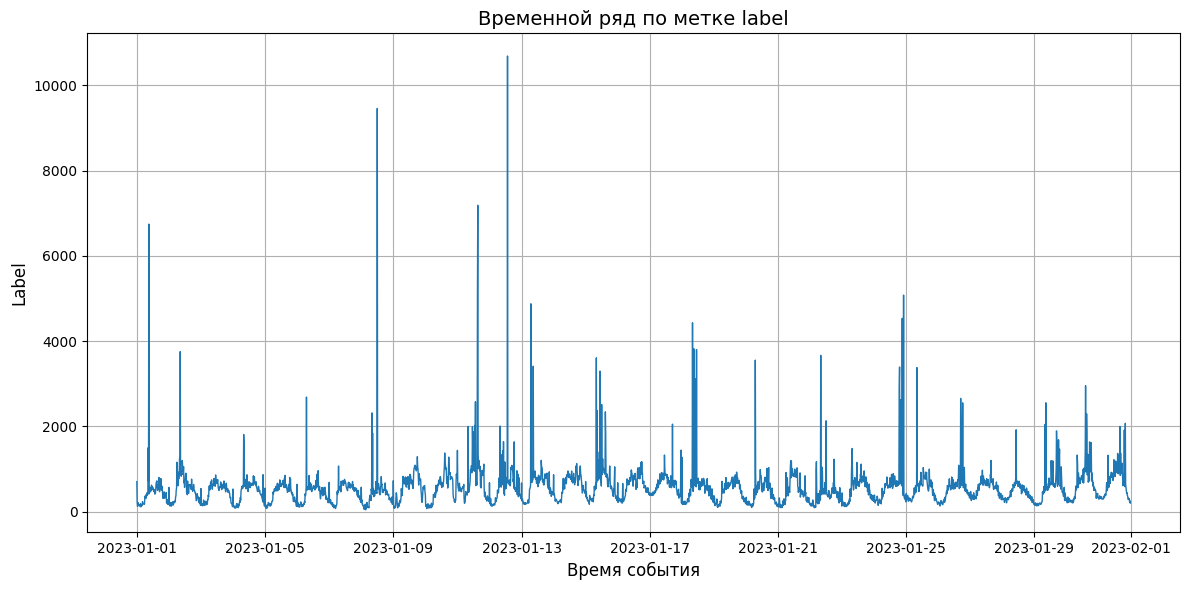

In [5]:
# строим график
plt.figure(figsize=(12, 6))
plt.plot(data['Event time'], data['label'], linestyle='-', linewidth=1)

# оформляем
plt.title('Временной ряд по метке label', fontsize=14)
plt.xlabel('Время события', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

### Декомпозиция временного ряда

Декомпозиция временного ряда нужна для того, чтобы разделить данные на несколько основных компонентов:
- Trend (тренд) — долгосрочное изменение уровня ряда.
- Seasonality (сезонность) — повторяющиеся паттерны (день недели, время суток и т.д.).
- Residuals (остатки) — случайные колебания, шум.

Такой подход помогает лучше понять структуру данных, выявить закономерности, а также подготовить ряд к моделированию: корректно учитывать сезонность, тренд и отсекать шум.


In [6]:
data.set_index('Event time', inplace=True)

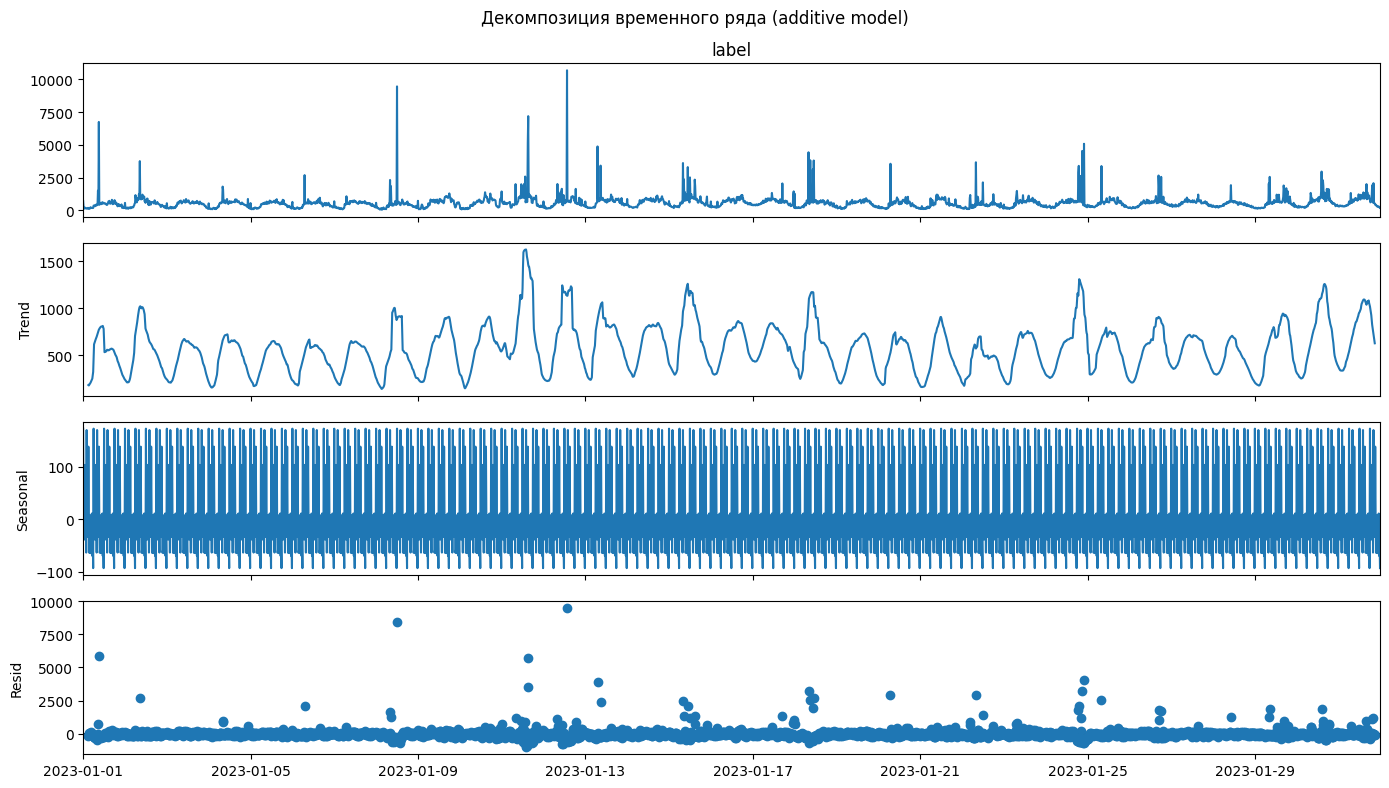

In [7]:
# декомпозиция
result = seasonal_decompose(
    data['label'],
    model='additive',
    period=24   # сутки для почасовых данных
)

# визуализация
fig = result.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Декомпозиция временного ряда (additive model)', fontsize=12)
plt.tight_layout()
plt.show()

### Анализ декомпозиции временного ряда

На графике представлены четыре компоненты временного ряда, полученные с помощью аддитивной декомпозиции:

#### 1. Исходный ряд
- Наблюдаются регулярные пики нагрузки.
- Значения сильно варьируются, что может указывать на всплески активности пользователей.
- Присутствуют как частые мелкие колебания, так и редкие высокие всплески.

#### 2. Trend (трендовая компонента)
- Тренд показывает плавные изменения общего уровня активности.
- Видны регулярные «волны», которые отражают циклическое изменение нагрузки в течение дней.
- После резких пиков тренд постепенно возвращается к среднему уровню.

#### 3. Seasonal (сезонная компонента)
- Чётко выраженная сезонность с фиксированным периодом.
- Повторяющиеся циклы указывают на типичное поведение пользователей в течение суток.
- Амплитуда сезонности стабильна — это подтверждает правильный выбор аддитивной модели.

#### 4. Residual (остатки)
- Остатки представляют случайные отклонения от тренда и сезонности.
- Большая часть точек находится около нуля — модель хорошо объясняет ряд.
- Сильные выбросы соответствуют редким аномально высоким значениям исходного ряда (например, пиковым событиям или всплескам активности).

### Вывод
Декомпозиция показала, что временной ряд состоит из:
- выраженной суточной сезонности,
- плавно меняющегося тренда,
- редких аномальных скачков нагрузки.

Это помогает лучше понять структуру данных и подготовить ряд к моделированию, прогнозированию или поиску аномалий.


### Проверка стационарности временного ряда

Проверка стационарности — важный этап анализа временных рядов, поскольку многие методы моделирования (например, ARIMA) предполагают работу именно со стационарными данными.

Стационарный ряд обладает следующими свойствами:
- постоянное среднее,
- постоянная дисперсия,
- отсутствие долгосрочного тренда,
- структура колебаний не меняется со временем.

Для проверки используется тест Дики–Фуллера (ADF-test):
- **H₀:** ряд нестационарен (имеет тренд или дрейф);
- **H₁:** ряд стационарен.

Если p-value ≤ 0.05 → отвергаем H₀ → ряд **стационарен**.

В результате теста для нашего ряда получено p-value = 0.0000, что значительно ниже 0.05 — это означает, что ряд можно считать стационарным и он подходит для моделирования алгоритмами, которые требуют стационарности.


In [8]:
result = adfuller(data['label'])

# вывод результата
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value:.3f}')

# интерпретация результатов
if result[1] <= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд  не стационарен (не отвергаем H0)")

ADF Statistic: -10.218298
p-value: 0.000000
Critical Values:
1%: -3.433
5%: -2.863
10%: -2.567
Ряд стационарен (отвергаем H0)


In [9]:
# выводим последние n дней
n_days = 7
n = 4 * 24 * n_days
data_fill = data.iloc[-n:,:] 

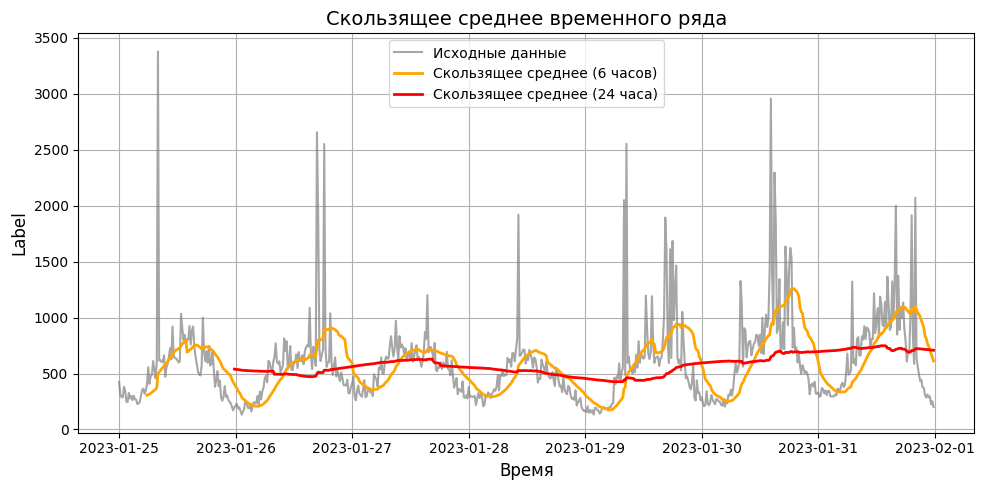

In [10]:
# применяем скользящее среднее
# ряд с интервалом 15 минут → 6 часов = 24 точки, 24 часа = 96 точек
data_fill['MA_6h'] = data_fill['label'].rolling(window=24).mean()
data_fill['MA_24h'] = data_fill['label'].rolling(window=96).mean()

# визуализация
plt.figure(figsize=(10, 5))
plt.plot(data_fill.index, data_fill['label'], label='Исходные данные', color='gray', alpha=0.7)
plt.plot(data_fill.index, data_fill['MA_6h'], label='Скользящее среднее (6 часов)', color='orange', linewidth=2)
plt.plot(data_fill.index, data_fill['MA_24h'], label='Скользящее среднее (24 часа)', color='red', linewidth=2)

plt.title('Скользящее среднее временного ряда', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Скользящее среднее временного ряда

На графике показаны:
- серым — исходные почасовые данные по показателю *Label*;
- оранжевым — скользящее среднее с окном 6 часов (сглаживает локальные колебания, но хорошо отражает краткосрочную динамику);
- красным — скользящее среднее с окном 24 часа (показывает суточный тренд).

Основные наблюдения:
- Исходный ряд содержит много шумовых колебаний и резких пиков нагрузки.
- Скользящее среднее с окном 6 часов сглаживает одиночные выбросы, но всё ещё реагирует на локальные изменения.
- Суточное скользящее среднее (24 часа) показывает более плавный тренд: общая динамика ряда остаётся относительно стабильной, без ярко выраженного постоянного роста или падения.
- Отдельные высокие пики в исходных данных не меняют долгосрочный тренд, но важны как потенциальные аномалии для дальнейшего анализа.

Использование скользящего среднего помогает уменьшить влияние шума и лучше увидеть общую тенденцию изменения показателя во времени.


### Анализ автокорреляции временного ряда

Для временного ряда дополнительно построены графики:
- ACF (Autocorrelation Function) — показывает, насколько текущие значения ряда связаны со своими прошлыми значениями на разных лагах.
- PACF (Partial Autocorrelation Function) — показывает «чистую» связь между значением ряда и его лагами с учётом промежуточных лагов.

Зачем это нужно:
- по ACF можно увидеть наличие сезонности и общую структуру зависимости во времени;
- по PACF удобно подбирать порядок моделей ARIMA/AR (количество значимых лагов);
- высокая автокорреляция на лагах, кратных 24, подтверждает суточную сезонность ряда.

Анализ этих графиков помогает выбрать подходящую модель для прогнозирования и лучше понять временную структуру данных.


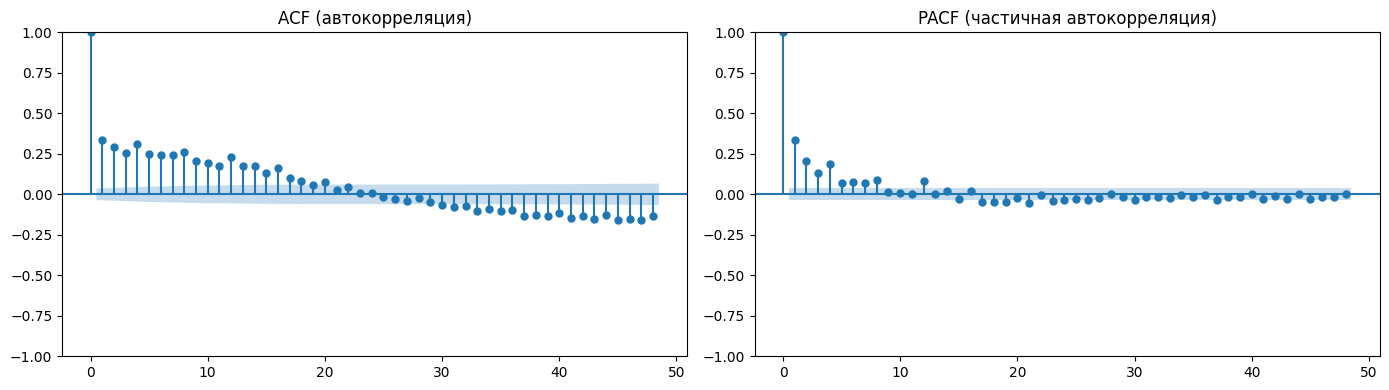

In [11]:
series = data['label']  # наш временной ряд

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF — автокорреляционная функция
plot_acf(series, lags=48, ax=axes[0])
axes[0].set_title('ACF (автокорреляция)')

# PACF — частичная автокорреляция
plot_pacf(series, lags=48, ax=axes[1])
axes[1].set_title('PACF (частичная автокорреляция)')

plt.tight_layout()
plt.show()

### Анализ автокорреляции временного ряда

На графиках представлены:

- ACF (автокорреляция) — показывает зависимость значений ряда от его прошлых значений на разных лагах.
- PACF (частичная автокорреляция) — показывает «чистый» вклад каждого лага с учётом промежуточных лагов.

Основные наблюдения:

- В ACF значение на малых лагах (особенно лаг 1) очень высокое и далее медленно убывает.  
  Это говорит о сильной зависимости текущего значения от недавних значений и «инерционности» ряда.
- В PACF ярко выделяется значимый первый лаг, а остальные лаги находятся близко к нулю (в пределах доверительных интервалов).  

### Как автокорреляция помогает выявлять временные зависимости?

Использование автокорреляции помогает в следующих задачах:

1. Выявление сезонности.  
   Если значения повторяются через фиксированные интервалы (например, каждую неделю или месяц), автокорреляция покажет пики на соответствующих лагах. Это помогает определить периодичность процессов.

2. Определение трендов.  
   Высокая автокорреляция на малых лагах часто указывает на наличие тренда: значения постепенно растут или падают, и каждое следующее значение коррелирует с предыдущими.

3. Обнаружение цикличности.  
   Автокорреляция позволяет увидеть циклы, которые не являются строгой сезонностью, но повторяются в данных с разной интенсивностью.

4. Оценка инерционности системы.  
   Если значения временного ряда сильно зависят от предыдущих, система обладает инерцией. Это важно, например, для прогнозирования нагрузки, продаж, активности пользователей и т. д.

5. Подготовка данных для моделей прогнозирования.  
   Зная автокорреляцию, можно понять, какие лаги стоит включить в модели (например, ARIMA), чтобы улучшить качество прогноза.

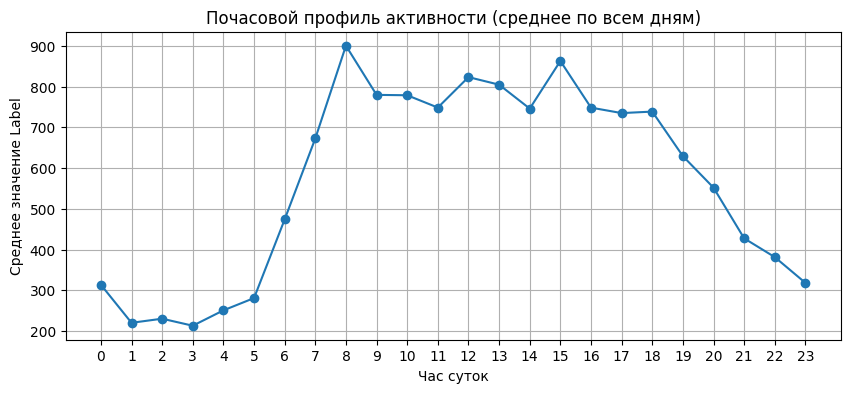

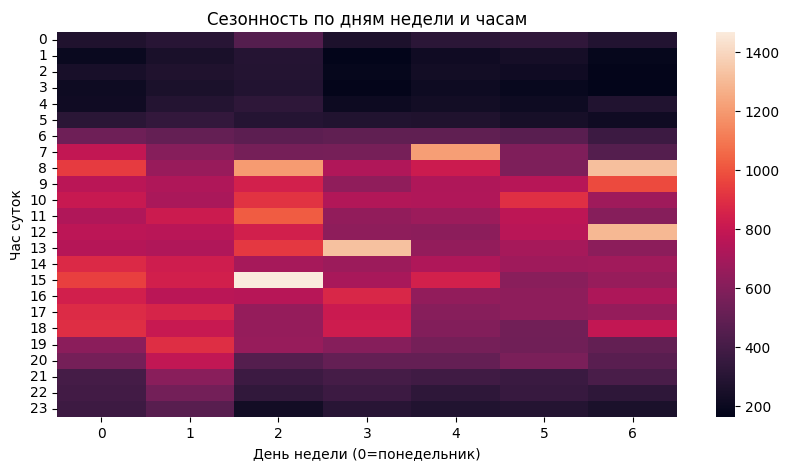

In [12]:
# почасовая сезонность (среднее по всем дням)
hourly_mean = data['label'].groupby(data.index.hour).mean()

plt.figure(figsize=(10, 4))
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.xticks(range(0, 24))
plt.title('Почасовой профиль активности (среднее по всем дням)')
plt.xlabel('Час суток')
plt.ylabel('Среднее значение Label')
plt.grid(True)
plt.show()

# сезонность "день недели × час" (тепловая карта)
dow_hour_mean = data['label'].groupby(
    [data.index.dayofweek, data.index.hour]
).mean().unstack(0)  # строки — часы, столбцы — дни недели

plt.figure(figsize=(10, 5))
sns.heatmap(dow_hour_mean, annot=False)
plt.title('Сезонность по дням недели и часам')
plt.xlabel('День недели (0=понедельник)')
plt.ylabel('Час суток')
plt.show()

### Анализ сезонности

На графиках показана сезонность показателя Label в разрезе часов суток и дней недели.

#### Почасовой профиль активности

- В ночные часы с 0 до 4 среднее значение Label минимально (≈ 220–280) — трафик почти отсутствует.
- Начиная примерно с 5–6 часов активность резко растёт.
- Максимальные значения наблюдаются в утренние и дневные часы (7–15) — среднее значение Label достигает 800–900.
- После 16–17 часов начинается постепенное снижение нагрузки.
- К позднему вечеру (после 20 часов) значения снова приближаются к минимальным.

Это подтверждает ярко выраженную суточную сезонность: основной объём событий приходится на рабочее дневное время.

#### Сезонность по дням недели и часам

- На тепловой карте видно, что повышенная активность в дневные часы повторяется почти во все дни недели.
- На будние дни (0–4) приходится больше всего «горячих» зон — нагрузка выше и стабильнее.
- В выходные (5–6) активность в целом ниже, особенно в утренние часы, но отдельные часы всё равно могут выделяться локальными пиками.
- Самые яркие зоны сосредоточены в интервале примерно 7–15 часов, что согласуется с почасовым профилем.

Вывод: временной ряд обладает устойчивой суточной и недельной сезонностью:  
основной трафик формируется в рабочие часы будних дней, тогда как ночи и выходные характеризуются сниженной активностью.


## Обнаружение аномалий во временных рядах

Аномалии во временных рядах — это неожиданные, нетипичные значения, которые выбиваются из общего паттерна сезонности и трендов. Их важно выявлять, поскольку они могут указывать на:

- технические сбои (например, резкий провал активности)
- всплески нагрузки из-за маркетинговых кампаний или внешних событий
- аномальное поведение пользователей
- ошибки сбора данных

### Как обнаруживать аномалии?

Существует несколько подходов:

### 1. Бизнес-правило  
 
Этот подход основан не на статистике, а на экспертных знаниях о бизнес-процессах.  
Мы заранее задаём пороги, которые не должны нарушаться при нормальном поведении системы.  
Если значение превышает или падает ниже установленного предела — это считается аномалией.

#### Когда применяется?
- когда хорошо известны типичные диапазоны значений
- когда отклонение от нормы напрямую связано с реальными бизнес-рисками
- когда данные нестабильны или малочисленны, и статистические методы работают хуже
- когда важно контролировать конкретные метрики (например, SLA, минимальный запас, лимиты нагрузки)

#### Почему это полезно?
- метод прост и не требует расчётов
- легко объясняется руководству
- позволяет быстро создавать “охранные барьеры” для ключевых бизнес-метрик
- помогает ловить редкие, но критичные сбои

Бизнес-правила хорошо работают как базовый уровень мониторинга и могут использоваться совместно со статистическими моделями — как дополнительная защита от неожиданных отклонений.

В качестве эксперимента мы будем рассматривать данные только за одну неделю. Это позволяет упростить визуализацию и сделать графики более наглядными: на коротком интервале лучше видны изменения метрики, колебания и возможные отклонения. Такой подход удобен для первичного анализа, чтобы быстро понять структуру данных и проверить работу бизнес-правил, прежде чем применять их ко всему датасету.


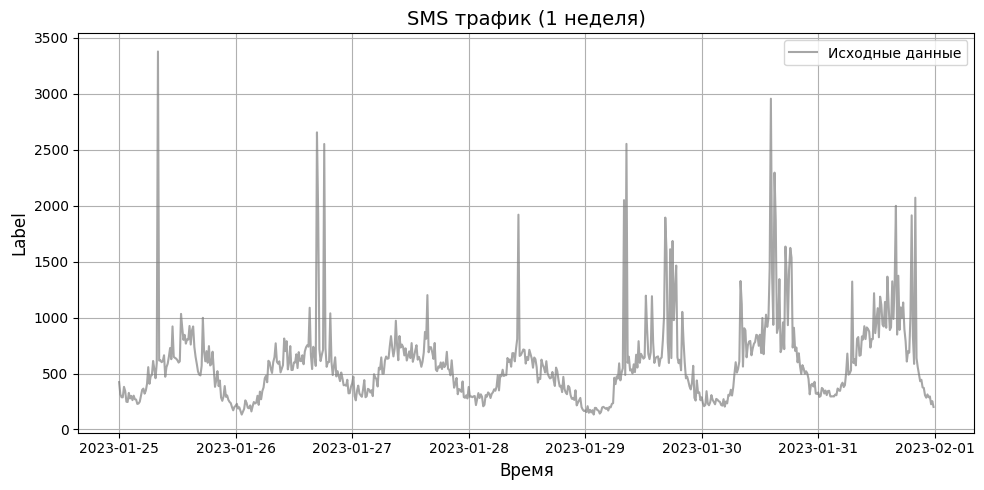

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(data_fill.index, data_fill['label'], label='Исходные данные', color='gray', alpha=0.7)
plt.title('SMS трафик (1 неделя)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На основе анализа графика выше можно ввести простое бизнес-правило, позволяющее автоматически фиксировать резкие всплески SMS-трафика.  

Если количество SMS-сообщений в конкретный момент превышает 1000, то это можно считать отклонением от нормального поведения системы. Такой порог выбран эмпирически: на графике видно, что типичные значения метрики колеблются значительно ниже, а пики заметно выделяются своей амплитудой.  

Использование такого простого правила помогает быстро обнаруживать потенциальные аномалии — например, подозрительные массовые рассылки, ошибки в системе или резкие изменения нагрузки. Это базовый, но эффективный способ контроля метрики без сложных статистических моделей.


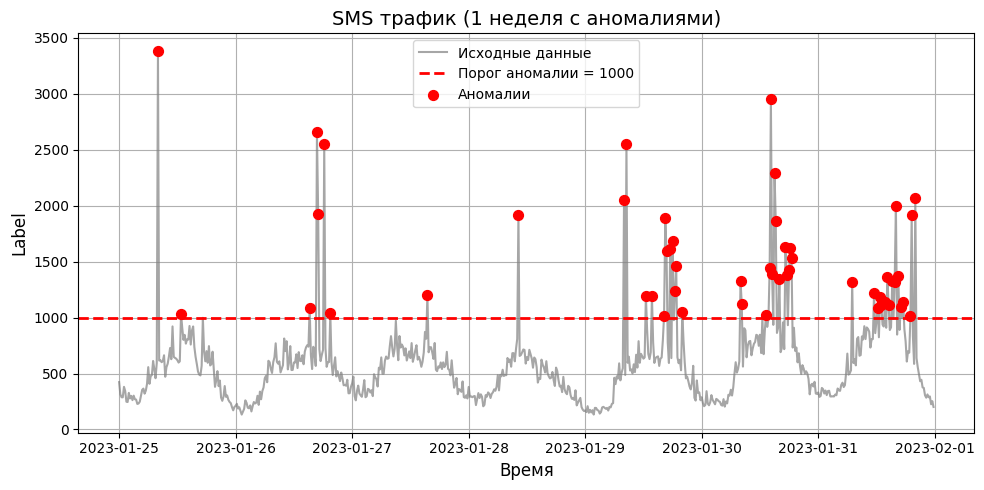

In [14]:
threshold = 1000

# фильтруем аномалии
anomalies = data_fill[data_fill['label'] > threshold]

plt.figure(figsize=(10, 5))

# основной ряд
plt.plot(
    data_fill.index,
    data_fill['label'],
    label='Исходные данные',
    color='gray',
    alpha=0.7
)

# линия порога
plt.axhline(
    y=threshold,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Порог аномалии = {threshold}'
)

# точки-анoмaлии
plt.scatter(
    anomalies.index,
    anomalies['label'],
    color='red',
    label='Аномалии',
    s=50,
    zorder=3
)

plt.title('SMS трафик (1 неделя с аномалиями)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

По графику видно, что недельный SMS-трафик имеет выраженную суточную цикличность: в дневные часы наблюдаются регулярные всплески нагрузки, а ночью значения метрики заметно снижаются. Отдельные пики значительно превосходят обычный уровень и именно они определяются моделью как аномалии по выбранному порогу.

Порог в 1000 сообщений позволяет наглядно отделить нормальное поведение от редких резких всплесков. Точки, превышающие этот уровень, действительно соответствуют нетипичным значениям и выделяются на фоне общей динамики.

Достоинства подхода:
- простая интерпретация порога, не требующая сложных вычислений
- быстрый способ обнаружить ярко выраженные выбросы
- подходит для первичного анализа данных и быстрого прототипирования
- работает даже на небольшом объёме данных

Недостатки подхода:
- фиксированный порог не учитывает естественные суточные колебания трафика
- чувствительность к выбору порога: слишком низкий создаёт лишние аномалии, слишком высокий скрывает настоящие
- не выявляет постепенные изменения тренда
- не учитывает контекст: одно и то же значение может быть нормальным в дневное время и аномальным ночью, но метод этого не различает


### 2. Среднее стандартное отклонение

В этом блоке оценивается разброс значений показателя Label и задаются простые статистические пороги для поиска аномалий.

Что делаем:
- Берём временной ряд Label.
- Считаем:
  - среднее значение mu
  - стандартное отклонение sigma
- Формируем пороги:
  - mu + 2σ — зона повышенных значений
  - mu + 3σ — зона потенциальных аномалий
- Отмечаем наблюдения, которые превышают mu + 3σ, как аномальные пики.

Зачем это нужно:
- Быстро выявить нетипичные всплески активности без сложных моделей
- Понять, насколько стабильным является ряд и есть ли периоды резких отклонений
- Получить базовую точку отсчёта для дальнейшего анализа (например, сравнения с сезонностью или автокорреляцией)

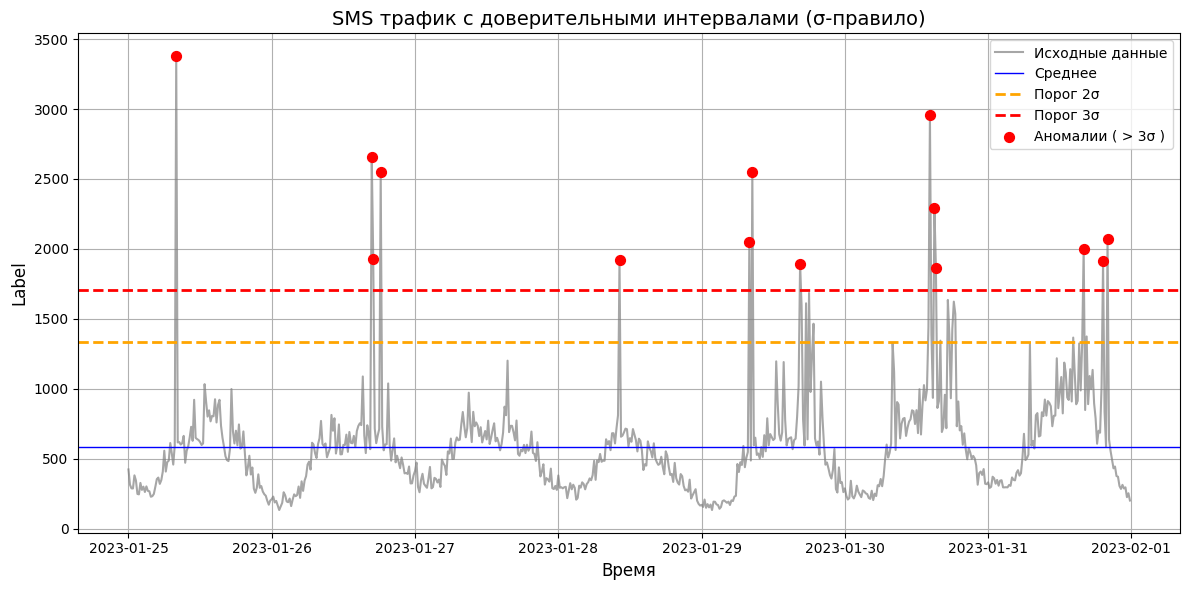

In [15]:
values = data_fill['label']

# расчёт статистик
mu = values.mean()
sigma = values.std()

# порог по 2σ и 3σ
threshold_2sigma = mu + 2 * sigma
threshold_3sigma = mu + 3 * sigma

# аномалии: выход за 3σ
anomalies = data_fill[values > threshold_3sigma]

plt.figure(figsize=(12, 6))

# основной ряд
plt.plot(
    data_fill.index,
    values,
    label='Исходные данные',
    color='gray',
    alpha=0.7
)

# линия среднего
plt.axhline(mu, color='blue', linestyle='-', linewidth=1, label='Среднее')

# 2σ доверительный интервал
plt.axhline(threshold_2sigma, color='orange', linestyle='--', linewidth=2, label='Порог 2σ')

# 3σ доверительный интервал
plt.axhline(threshold_3sigma, color='red', linestyle='--', linewidth=2, label='Порог 3σ')

# аномалии (выход за 3σ)
plt.scatter(
    anomalies.index,
    anomalies['label'],
    s=50,
    color='red',
    label='Аномалии ( > 3σ )',
    zorder=5
)

plt.title('SMS трафик с доверительными интервалами (σ-правило)', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике показан недельный SMS-трафик вместе с доверительными интервалами, рассчитанными на основе среднего значения и стандартного отклонения. Серым цветом отображён исходный временной ряд, который демонстрирует выраженные суточные колебания и периодические резкие всплески нагрузки.

Синяя линия обозначает среднее значение метрики за период. 
- Порог в две сигмы (оранжевая пунктирная линия) показывает область умеренно повышенных значений, которые могут указывать на необычное поведение, но не обязательно являются аномалиями. 
- Порог в три сигмы (красная пунктирная линия) служит границей, выше которой значения считаются статистически редкими и потенциально аномальными. Именно эти точки выделены красными маркерами на графике.

Подход на основе среднего и стандартного отклонения позволяет учитывать общую вариативность данных и автоматически адаптирует пороги к уровню разброса метрики. Однако суточная сезонность остаётся видимой: допускаемые значения в ночные часы оказываются намного ниже дневных, что усложняет интерпретацию аномалий при использовании глобальных порогов.

### 3. Скользящее среднее и стандартное отклонение  
Простая и эффективная методика:  

- вычисляется скользящее среднее (MA) и стандартное отклонение (STD)  
- точка считается аномальной, если:  
  |value − MA| > k × STD, где k чаще всего берут 2 или 3

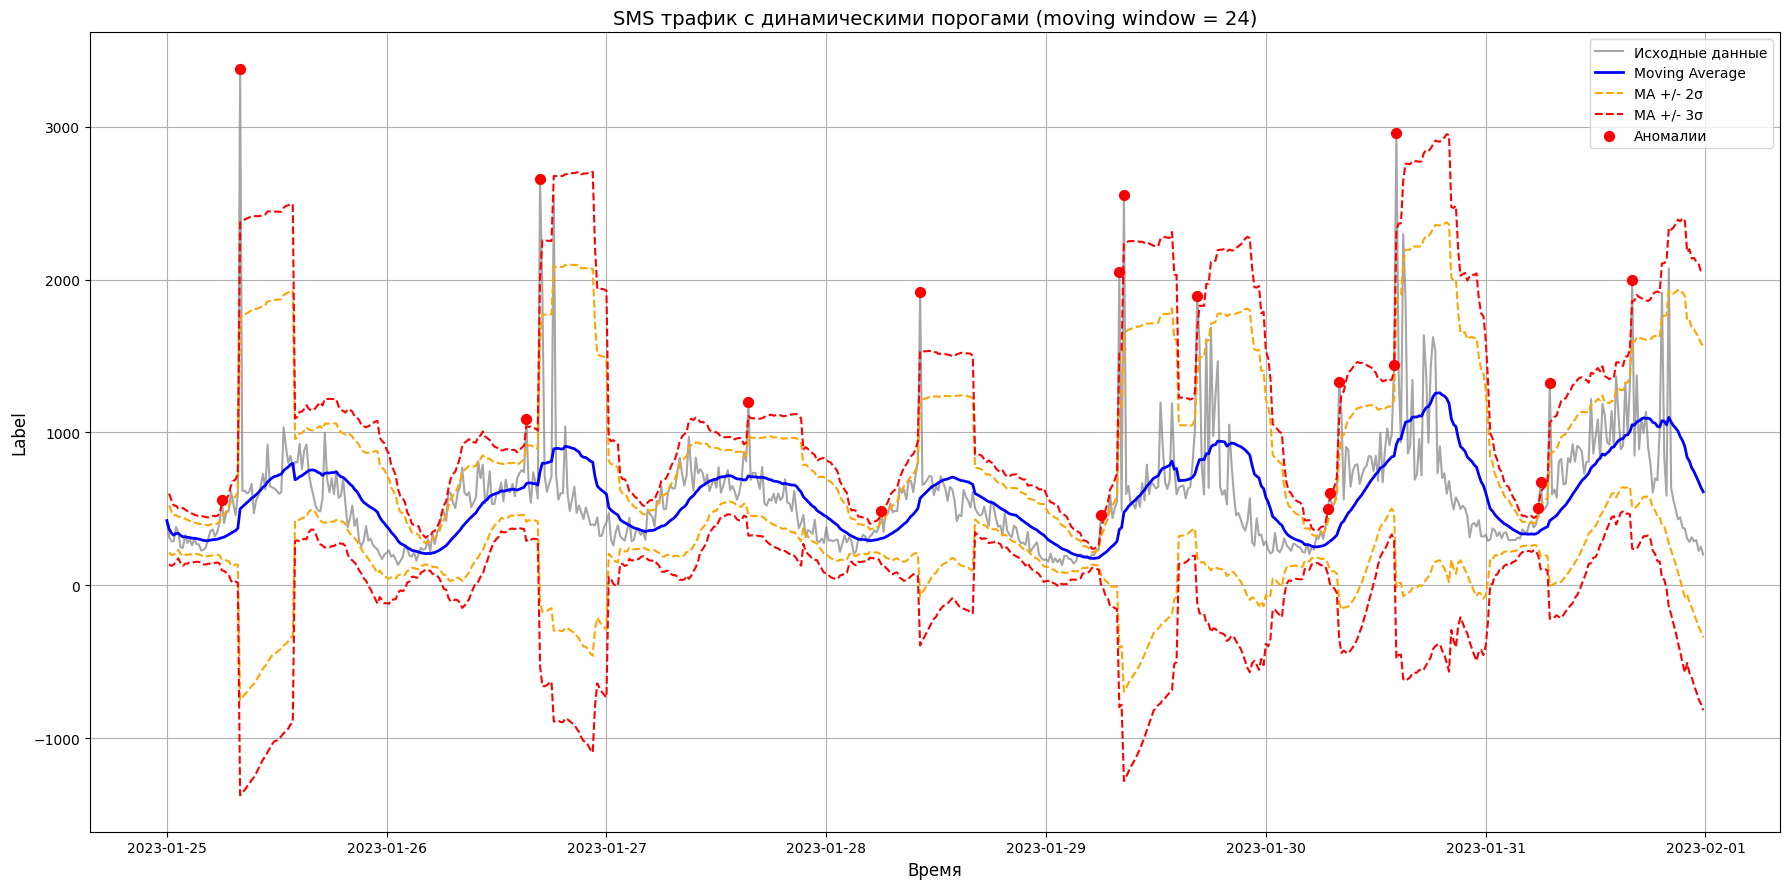

In [16]:
# выбираем окно (например, 24 точки)
window = 24

# скользящее среднее
ma = data_fill['label'].rolling(window=window, min_periods=1).mean()

# скользящее стандартное отклонение
std = data_fill['label'].rolling(window=window, min_periods=1).std()

# динамические пороги 2σ и 3σ
upper_2sigma = ma + 2 * std
upper_3sigma = ma + 3 * std

lower_2sigma = ma - 2 * std
lower_3sigma = ma - 3 * std

# аномалии: выход за 3σ
anomalies = data_fill[(data_fill['label'] > upper_3sigma) | (data_fill['label'] < lower_3sigma)]


plt.figure(figsize=(18, 9))

# исходные данные
plt.plot(
    data_fill.index, data_fill['label'], label='Исходные данные', color='gray', alpha=0.7
)

# скользящее среднее
plt.plot(
    data_fill.index, ma, label='Moving Average', color='blue', linewidth=2
)

# 2σ порог
plt.plot(
    data_fill.index, upper_2sigma, label='MA +/- 2σ', color='orange', linestyle='--'
)

plt.plot(
    data_fill.index, lower_2sigma, color='orange', linestyle='--'
)

# 3σ порог
plt.plot(
    data_fill.index, upper_3sigma, label='MA +/- 3σ', color='red', linestyle='--'
)

plt.plot(
    data_fill.index, lower_3sigma, color='red', linestyle='--'
)

# аномалии
plt.scatter(
    anomalies.index, anomalies['label'], color='red', s=50, label='Аномалии', zorder=5
)

plt.title(f'SMS трафик с динамическими порогами (moving window = {window})', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике показан недельный SMS-трафик, к которому применён подход с динамическими порогами, основанный на скользящем среднем и стандартном отклонении (окно сглаживания — 24 точки). Серым цветом отображён исходный временной ряд, который содержит чёткую суточную сезонность и ряд резких всплесков нагрузки.

Синяя линия — скользящее среднее (MA), отражающее сглаженное поведение метрики и показывающее общую динамику без резких колебаний. Оранжевая и красная пунктирные линии представляют уровни MA + 2σ и MA + 3σ соответственно, формируя адаптивные пороги, которые изменяются вместе с самой метрикой. Это позволяет учитывать локальные изменения и естественный суточный цикл.

Красными точками выделены значения, превышающие динамический порог MA + 3σ, то есть статистически редкие наблюдения, которые можно рассматривать как аномалии. Видно, что большая часть аномальных точек действительно соответствует резким пикам трафика, а в периоды низкой активности метод корректно не реагирует на ночные колебания.

Дополнительно важно учитывать нижние динамические границы (MA − 2σ и MA − 3σ). Они отражают не только нормальный диапазон колебаний, но и помогают фиксировать аномалии снижения трафика.

Зачем это нужно:
- Нижние выбросы могут указывать на технические сбои, задержки доставки, проблемы с сетевой инфраструктурой, ограничение рассылок или неполные данные.
- Такие провалы часто не менее критичны, чем пики, так как могут означать недополучение трафика и скрытые потери бизнес-активности.

Подход с динамическими порогами лучше отражает структуру данных по сравнению с фиксированным порогом, так как он автоматически адаптируется к сезонности и локальным изменениям уровня метрики. Однако сильные всплески по-прежнему выделяются как аномалии, что делает этот метод более гибким, но при этом продолжающим эффективно указывать на выбросы.


### Сравнение методов
Теперь, сравнивая все три подхода — фиксированное бизнес-правило, статистический порог (среднее + σ) и динамические пороги (скользящее среднее + σ), можно определить, какой из методов работает лучше всего в условиях анализа SMS-трафика.

- Бизнес-правило основано на заранее установленном фиксированном пороге (например, 1000 сообщений). Его преимущество — простота и мгновенная интерпретация: руководителю или инженеру легко понять, что любое значение выше X — это потенциальная проблема. Однако недостаток в том, что такой порог не учитывает естественную сезонность данных. В дневные часы нормальная нагрузка может превышать фиксированный порог, создавая большое количество ложных аномалий. Ночные значения, наоборот, могут быть слишком низкими, но при фиксированном пороге не будут замечены.

- Статические пороги по среднему и + σ уже более чувствительны к распределению данных. Они позволяют учитывать общий уровень вариации, но остаются глобальными по отношению ко всему периоду. Из-за сезонности SMS-трафика (суточные циклы) такой метод также не всегда корректен: то, что днём выглядит нормой, ночью может оказаться статистически значимым отклонением.

- Динамические пороги (скользящее среднее + σ) — наиболее адаптивный подход. Пороговые линии меняются вместе с уровнем метрики, корректно повторяя сезонный паттерн. Благодаря этому метод выделяет только действительно редкие всплески, игнорируя регулярные дневные пики и естественные ночные провалы. Количество ложных срабатываний значительно ниже, а поведение порогов соответствует реальной структуре данных.
  
Лучший результат показывает метод с динамическими порогами. Он сочетает адаптивность, устойчивость к сезонности и способность выявлять действительно аномальные события. Бизнес-правило остаётся полезным для простых случаев и быстрой первичной фильтрации, но для анализа сложного временного ряда с регулярными колебаниями динамические пороги обеспечивают наибольшую точность и практическую ценность.


### Прогнозирование SMS трафика

Мы будем прогнозировать данные на след день на основе 6 предыдущих дней
- Методы:
    - 1 - прогнозирование глобальным средним 
    - 2 - прогнозирование средним в определенный период времени (утро, день, вечер, ночь)
    - 3 - прогнозирование средним в каждый интервал времени (каждые 15 минут)

Для расчета средних мы будет использовать разную глубину данных (1 день, 3 дня и 6 дней)

In [17]:
# разобьем данные на тестовую и тренировочную выборки
df = data_fill.sort_index().copy()
df_train, df_test = data_fill.loc[:'2023-01-30 23:45:00'], data_fill.loc['2023-01-31 00:00:00':]

В этом шаге мы делим данные на две части: train и test.  
- Тренировочная выборка (train) содержит исторические данные, на основе которых мы рассчитываем различные средние значения и формируем правила прогнозирования.  
- Тестовая выборка (test) — это данные за последний день, на которых мы проверяем качество прогноза.

Далее мы будем прогнозировать значения SMS-трафика с помощью простых методов усреднения.  

### Прогнозирование глобальным средним

В этом подходе мы используем самое простое правило: прогнозируем каждую точку следующего дня как одно общее среднее значение, рассчитанное на основе тренировочного периода.

То есть мы берём все данные за предыдущие 6 дней, вычисляем одно среднее значение SMS-трафика и считаем его прогнозом для всех интервалов следующего дня. Такой метод игнорирует сезонность, суточные циклы и локальные всплески, но служит простой базовой моделью, с которой можно сравнивать более сложные методы.

Преимущества:
- очень простая и быстрая модель
- даёт baseline, относительно которого удобно сравнивать другие методы

Недостатки:
- не учитывает суточные паттерны
- плохо работает при резких колебаниях и пиковых значениях
- одинаковое значение прогноза для всех 96 интервалов следующего дня

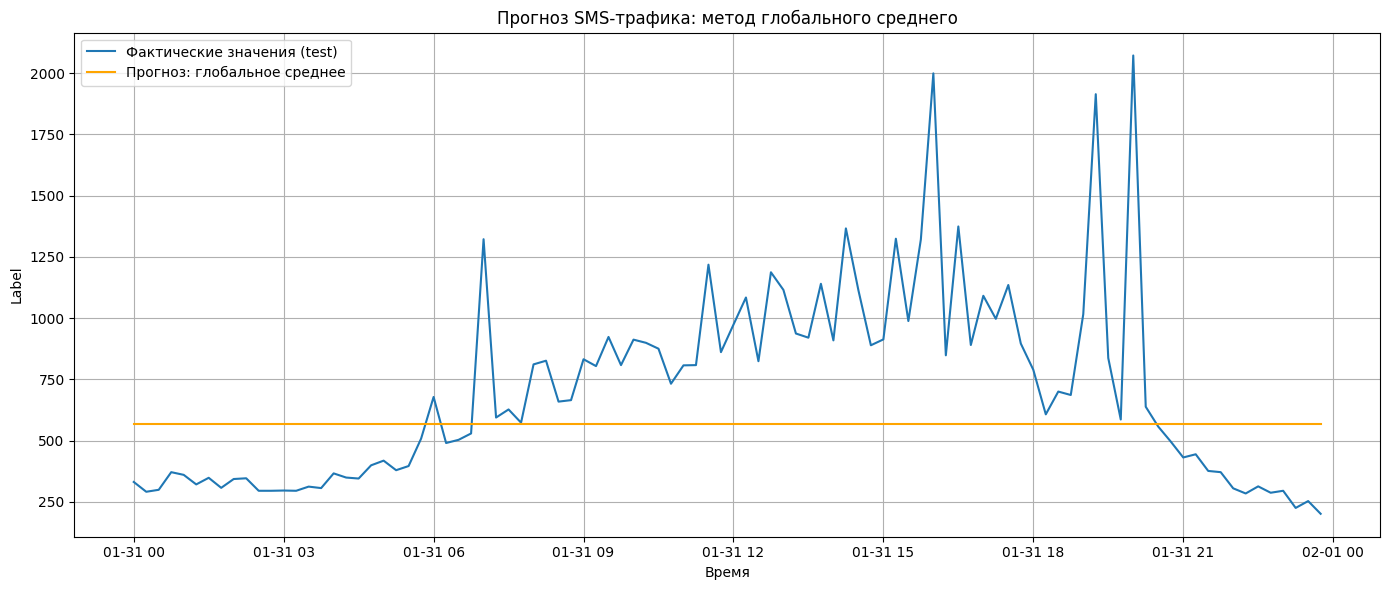

In [18]:
# среднее значение по обучающей выборке
global_mean = df_train['label'].mean()

# прогноз на следующий день 
y_pred_mean = [global_mean] * len(df_test)

# График
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test['label'], label='Фактические значения (test)')
plt.plot(df_test.index, y_pred_mean, label='Прогноз: глобальное среднее', color='orange')
plt.title('Прогноз SMS-трафика: метод глобального среднего')
plt.xlabel('Время')
plt.ylabel('Label')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


На графике показано сравнение фактического SMS-трафика за тестовый день и прогноза,
полученного с помощью метода глобального среднего. Синяя линия отражает реальное поведение
трафика в течение суток: в первой половине дня значения постепенно растут, затем наблюдаются
значительные пики нагрузки и дальнейшее снижение к вечеру и ночи.

Оранжевая линия представляет собой прогноз, который во всех интервалах равен одному и тому же
значению — среднему трафику за предыдущие дни. Этот метод хорошо работает как базовая точка
отсчёта (baseline), но он не учитывает суточные колебания, интервальные паттерны и резкие всплески
нагрузки. В результате прогнозная линия заметно отклоняется от фактических значений, особенно
в периоды роста и пиков активности.


### Прогнозирование средним в определённый период суток

В этом методе мы группируем весь тренировочный датасет на четыре периода:
- утро (06:00–12:00)
- день (12:00–18:00)
- вечер (18:00–00:00)
- ночь (00:00–06:00)

Для каждого периода рассчитывается своё среднее значение трафика. Далее, чтобы построить прогноз на следующий день, мы для каждого момента времени выбираем среднее значение именно того периода, к которому относится данный интервал.

Этот метод более точный, чем глобальное среднее, потому что:
- учитывает суточные паттерны трафика
- различает активные и спокойные временные промежутки
- лучше моделирует поведение трафика в течение дня

Недостатки:
- всё ещё игнорирует различия между днями недели,
- не предсказывает резкие всплески, так как работает только со средними значениями.


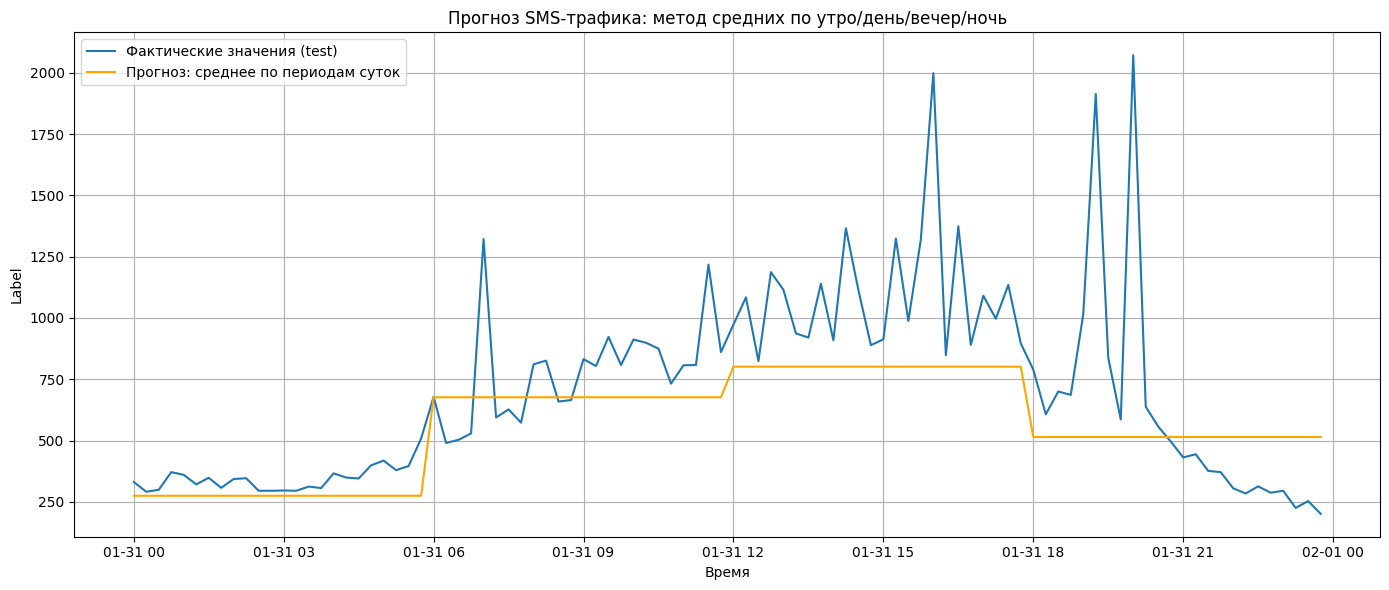

In [19]:
# функция для определения периода
def get_period(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "day"
    elif 18 <= hour < 24:
        return "evening"
    else:
        return "night"

# добавляем период в train и test
df_train['hour'] = df_train.index.hour
df_test['hour'] = df_test.index.hour

df_train['period'] = df_train['hour'].transform(get_period)
df_test['period'] = df_test['hour'].transform(get_period)

# средние по каждому периоду
period_means = df_train.groupby('period')['label'].mean()

# прогноз для тестового дня
y_pred_period = [period_means[p] for p in df_test['period']]

# график
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test['label'], label='Фактические значения (test)')
plt.plot(df_test.index, y_pred_period, label='Прогноз: среднее по периодам суток', color='orange')
plt.title('Прогноз SMS-трафика: метод средних по утро/день/вечер/ночь')
plt.xlabel('Время')
plt.ylabel('Label')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



На графике показано сравнение фактического SMS-трафика за тестовый день
и прогноза, построенного методом средних по периодам суток
(утро, день, вечер, ночь).

- Фактические данные (синяя линия) демонстрируют характерную динамику:
утренний рост, более высокие значения днём и множественные резкие всплески нагрузки,
которые метод не способен предсказать.

- Прогноз (оранжевая линия) принимает четыре разные ступеньки —
каждая соответствует среднему трафику для своего периода суток.
Такой подход лучше глобального среднего, так как отражает суточную структуру
и различает активные и спокойные части дня. Однако модель всё ещё остаётся
очень грубой и не улавливает быстрых изменений и резких пиков,
поэтому прогноз выглядит сглаженным и отстаёт от реальных значений.


### Прогнозирование средним в каждом интервале времени (каждые 15 минут)

В этом методе мы используем тот факт, что трафик SMS имеет чёткую внутри¬дневную структуру.
Каждый интервал времени (например, 01:15, 01:30, 01:45, 02:00 и т. д.) обычно имеет своё 
среднее историческое значение, повторяющееся изо дня в день.

Алгоритм метода:
1. Из тренировочного периода выбираем значения для каждого точного интервала времени 
   (например, все значения за 6 дней в 09:30)
2. Для каждого интервала считаем среднее значение
3. Формируем прогноз для тестового дня, подставляя среднее значение соответствующего интервала

Этот метод учитывает суточную структуру трафика намного точнее, чем глобальные средние и 
периоды суток, так как прогноз строится для каждого из 96 интервалов.

Преимущества:
- хорошо подходит при стабильной суточной сезонности
- точно повторяет форму дня
- прост в реализации

Недостатки:
- требует ровного временного ряда (одинаковый шаг 15 минут)
- не работает хорошо при пропусках данных
- не предсказывает резкие аномалии


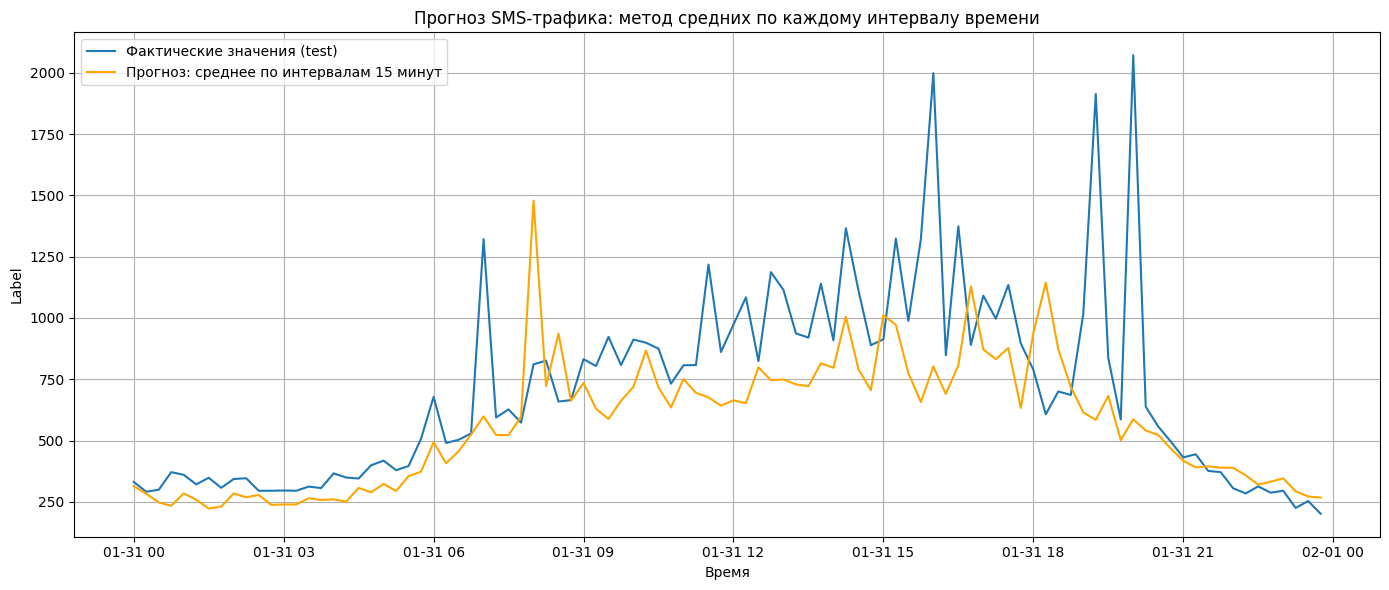

In [20]:
# группировка по времени внутри дня
df_train['time'] = df_train.index.time
df_test['time'] = df_test.index.time

# считаем среднее значение для каждого 15-минутного интервала
interval_means = df_train.groupby('time')['label'].mean()

# формируем прогноз для тестового дня
y_pred_interval = [interval_means[t] for t in df_test['time']]

# 4. График результата
plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test['label'], label='Фактические значения (test)')
plt.plot(df_test.index, y_pred_interval, label='Прогноз: среднее по интервалам 15 минут', color='orange')
plt.title('Прогноз SMS-трафика: метод средних по каждому интервалу времени')
plt.xlabel('Время')
plt.ylabel('Label')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

На графике показано сравнение фактического SMS-трафика за тестовый день
и прогноза, построенного методом средних по каждому интервалу времени
(каждые 15 минут).

- Фактические значения (синяя линия) демонстрируют динамичное поведение —
плавный рост утром, более высокая активность днём и множество резких пиков,
связанных с нагрузкой.

- Прогноз (оранжевая линия) формируется на основе среднего значения трафика
для каждого конкретного 15-минутного интервала, рассчитанного по историческим данным.
Этот метод лучше предыдущих: он учитывает тонкую суточную структуру трафика,
повторяющиеся паттерны по времени и даёт более плавную и реалистичную линию.

Однако значительные всплески трафика метод всё ещё не предсказывает,
поскольку такие пики случайны и отсутствуют в среднем поведении интервалов.
Поэтому прогноз находится близко к общей динамике, но не воспроизводит экстремальные значения.


### Оценка качества прогнозирования 

В этом разделе оцениваем качество трех примененных методов прогнозирования и сравниваем их по стандартным метрикам ошибок. Цель — выбрать наиболее надежный подход для практического использования и показать, чем он лучше альтернатив.

### Почему нужны метрики ошибок?

Визуальная проверка графиков полезна, но субъективна. Метрики позволяют:
- объективно сравнить методы на одном горизонте прогнозирования
- понять величину типичной ошибки
- выбрать метод, который устойчивее работает на разных участках ряда

### Используемые метрики

Для сравнения применяем три метрики: MSE, RMSE и MAE.

1) MSE (Mean Squared Error) — средняя квадратичная ошибка:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

Особенность: сильнее штрафует большие ошибки, поэтому чувствительна к выбросам.

2) RMSE (Root Mean Squared Error) — корень из средней квадратичной ошибки:

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

Удобна тем, что выражается в тех же единицах, что и исходный ряд.

3) MAE (Mean Absolute Error) — средняя абсолютная ошибка:

$$
MAE = \frac{1}{n}\sum_{i=1}^{n}\lvert y_i - \hat{y}_i \rvert
$$

Интерпретируется как средняя величина ошибки без усиленного штрафа за выбросы.

### Какая метрика будет основной

Для итогового ранжирования разумно использовать RMSE:
- она учитывает большие промахи сильнее, чем MAE
- остается интерпретируемой в исходных единицах
- хорошо подходит для задач мониторинга нагрузки и планирования ресурсов

При этом MAE можно рассматривать как дополнительную устойчивую оценку, особенно если в данных встречаются единичные пики.

### Логика сравнения

1. Рассчитываем MSE, RMSE и MAE для каждого из трех методов на одном и том же тестовом интервале
2. Сводим результаты в одну таблицу
3. Ранжируем методы по RMSE
4. Делаем вывод о лучшем методе и его практической применимости

In [30]:
# расчёт mse, rmse, mae для метода глобального среднего
y_true_1 = df_test['label'].values
y_pred_1 = y_pred_mean

# расчёт метрик
mse = mean_squared_error(y_true_1, y_pred_1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_1, y_pred_1)

print(f"mse {mse:.2f}")
print(f"rmse {rmse:.2f}")
print(f"mae {mae:.2f}")

mse 173957.00
rmse 417.08
mae 320.24


In [26]:
# расчёт mse, rmse, mae для среднего в определённый период суток
y_true_period = df_test['label'].values
y_pred_period_arr = np.array(y_pred_period)

# расчёт метрик
mse_period = mean_squared_error(y_true_period, y_pred_period_arr)
rmse_period = np.sqrt(mse_period)
mae_period = mean_absolute_error(y_true_period, y_pred_period_arr)

print(f"mse: {mse_period:.2f}")
print(f"rmse: {rmse_period:.2f}")
print(f"mae: {mae_period:.2f}")

mse:  107975.87
rmse: 328.60
mae:  207.28


In [27]:
# расчёт mse, rmse, mae для среднего в каждом интервале (15 минут)
y_true_interval = df_test['label'].values
y_pred_interval_arr = np.array(y_pred_interval)

# расчёт метрик
mse_interval = mean_squared_error(y_true_interval, y_pred_interval_arr)
rmse_interval = np.sqrt(mse_interval)
mae_interval = mean_absolute_error(y_true_interval, y_pred_interval_arr)

print(f"mse: {mse_interval:.2f}")
print(f"rmse: {rmse_interval:.2f}")
print(f"mae: {mae_interval:.2f}")

mse: 105891.42
rmse: 325.41
mae: 196.28


In [33]:
# объединение результатов по метрикам 
results = pd.DataFrame({
    "Метод": [
        "Глобальное среднее",
        "Среднее по периодам суток",
        "Среднее по 15-мин интервалам"
    ],
    "MSE": [mse, mse_period, mse_interval],
    "RMSE": [rmse, rmse_period, rmse_interval],
    "MAE": [mae, mae_period, mae_interval]
})

results.sort_values(by='RMSE', ascending=True)

,Метод,MSE,RMSE,MAE
2,Среднее по 15-мин интервалам,105891.420718,325.409620,196.281250
1,Среднее по периодам суток,107975.871528,328.596822,207.283131
0,Глобальное среднее,173957.004425,417.081532,320.242983


### Итоговый вывод по сравнению методов прогнозирования

1. Среднее по 15-минутным интервалам является лучшим методом  
   Метрики MSE, RMSE и MAE минимальны, что подтверждает более точное воспроизведение суточной структуры трафика  
   Метод учитывает ровный временной шаг и стабильно отражает реальный профиль нагрузки

2. Среднее по периодам суток (утро, день, вечер, ночь) показывает более высокие ошибки  
   Такой метод учитывает сезонность, однако использует слишком крупную группировку, из-за чего теряются детали внутри суток

3. Глобальное среднее — самый простой и самый неточный подход 
   Он игнорирует сезонность, пики нагрузки и суточную динамику. Подходит только как baseline

### Почему основной метрикой выбрана RMSE?

Метрика RMSE усиливает влияние крупных ошибок из-за квадратов отклонений.  
Для временных рядов нагрузки (например, телеком-трафика), резкие пики особенно важны, потому что именно они приводят к перегрузкам систем.  

RMSE позволяет корректно оценить, насколько хорошо метод справляется с прогнозированием экстремальных значений.


# Заключение

В ходе работы был выполнен анализ временного ряда SMS-трафика, включающий обработку данных, поиск аномалий и построение базовых моделей прогнозирования.

### 1. Подготовка временного ряда
- Проведена сортировка данных
- Выполнено заполнение пропусков
- Ряд приведён к равномерному временному шагу
- Построено сглаживание для выявления структуры

### 2. Анализ и обнаружение аномалий
Для выявления необычных всплесков и провалов использованы три подхода:
1. Бизнес-правило — фиксированный порог, заданный исходя из требований сервиса. Подходит для быстрого обнаружения критичных превышений
2. Глобальное среднее и стандартное отклонение (µ ± 2σ, µ ± 3σ) — позволяет выявлять как умеренные, так и сильные аномалии по всему периоду, но не учитывает сезонность
3. Скользящее среднее и скользящее стандартное отклонение — адаптивные пороги, которые обновляются в каждом окне. Такой метод лучше всего обнаруживает локальные аномалии и учитывает суточные колебания трафика

Использование нескольких подходов позволило выявить как резкие всплески, так и аномальные падения нагрузки.

### 3. Прогнозирование тремя методами
- Глобальное среднее
- Среднее по периодам суток
- Среднее по каждому 15-минутному интервалу
- Построены графики прогнозов

### 4. Оценка качества прогнозов
- Рассчитаны метрики MSE, RMSE, MAE для всех моделей
- Результаты сведены в общую таблицу
- Модели отсортированы по значению RMSE
- Выбран наиболее точный метод

Работа показала важность предварительного анализа временного ряда, выявления аномалий и корректного выбора модели.  
Среднее по 15-минутным интервалам является лучшим среди рассмотренных методов и служит качественной отправной точкой для построения более продвинутых моделей (ARIMA, Prophet, ML).
